In [50]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler,PowerTransformer
import lightgbm as lgb

In [51]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [94]:
df = pd.read_csv('data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [53]:
2151264665%15

5

In [54]:
data = df[['6','7']]
data

,6,7
Ngày,,
01/01/2021,964.4,964.4
01/02/2021,1019.7,1019.7
01/03/2021,988.4,988.4
01/04/2021,1002.0,1002.0
01/05/2021,1061.5,1061.5
...,...,...
27/12/2021,1002.0,1002.0
28/12/2021,1002.0,1002.0
29/12/2021,1061.5,1061.5


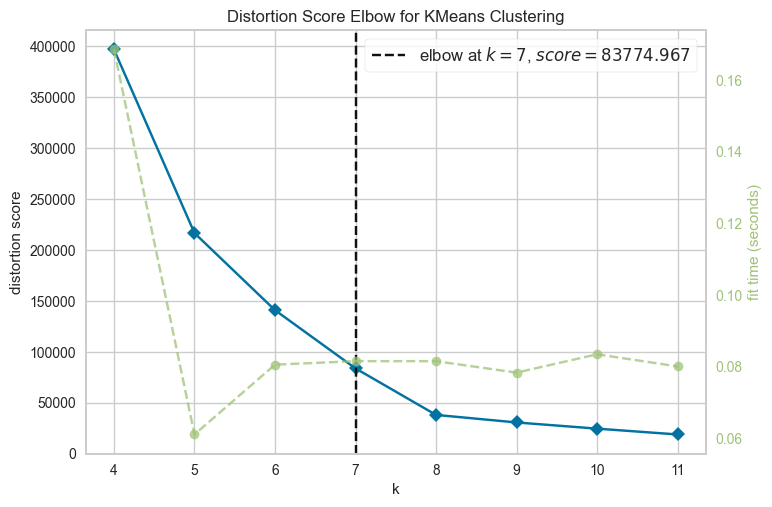

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

# Box plot

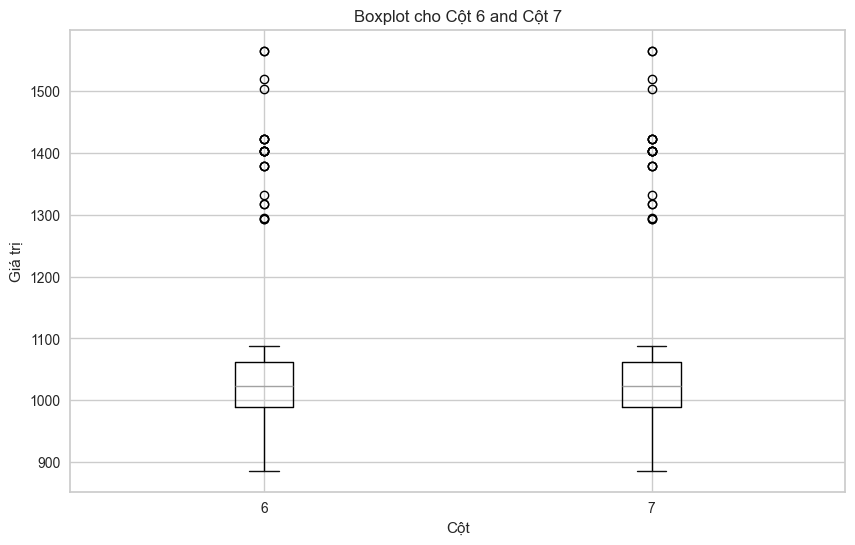

In [56]:
# Tạo boxplot cho cả hai cột
plt.figure(figsize=(10, 6))
data.boxplot()

# Thêm tiêu đề và nhãn trục
plt.title('Boxplot cho Cột 6 and Cột 7')
plt.ylabel('Giá trị')
plt.xlabel('Cột')
plt.show()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


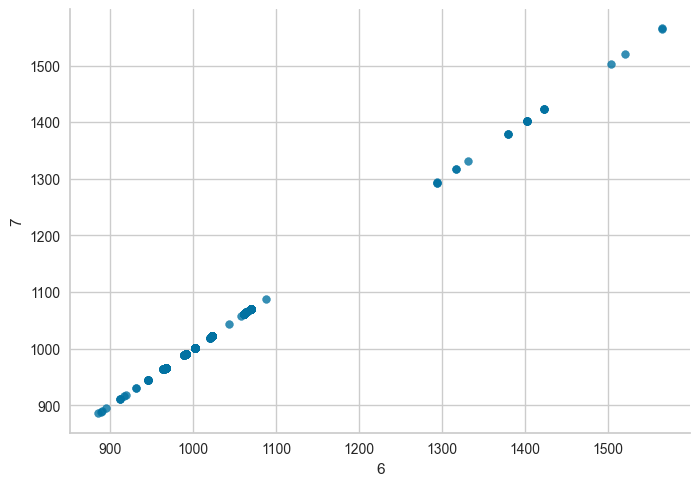

In [136]:
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='6', y='7', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# Biểu đồ đường

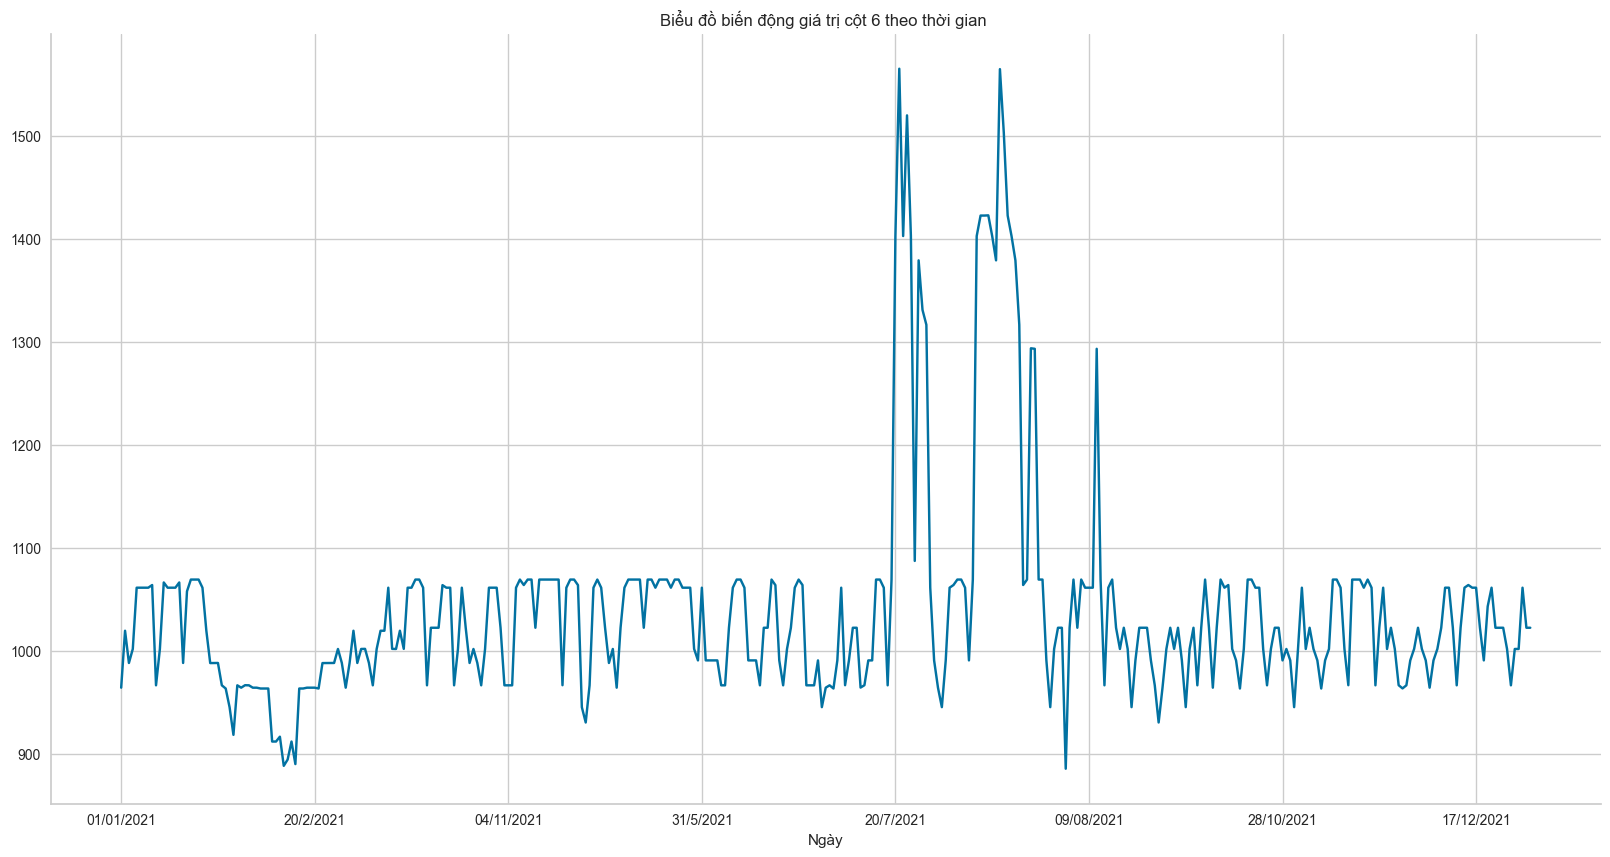

In [57]:
plt.figure(figsize=(20,10))
data['6'].plot(kind='line',figsize=(20,10),title="Biểu đồ biến động giá trị cột 6 theo thời gian ")
plt.gca().spines[['top','right']].set_visible(False)


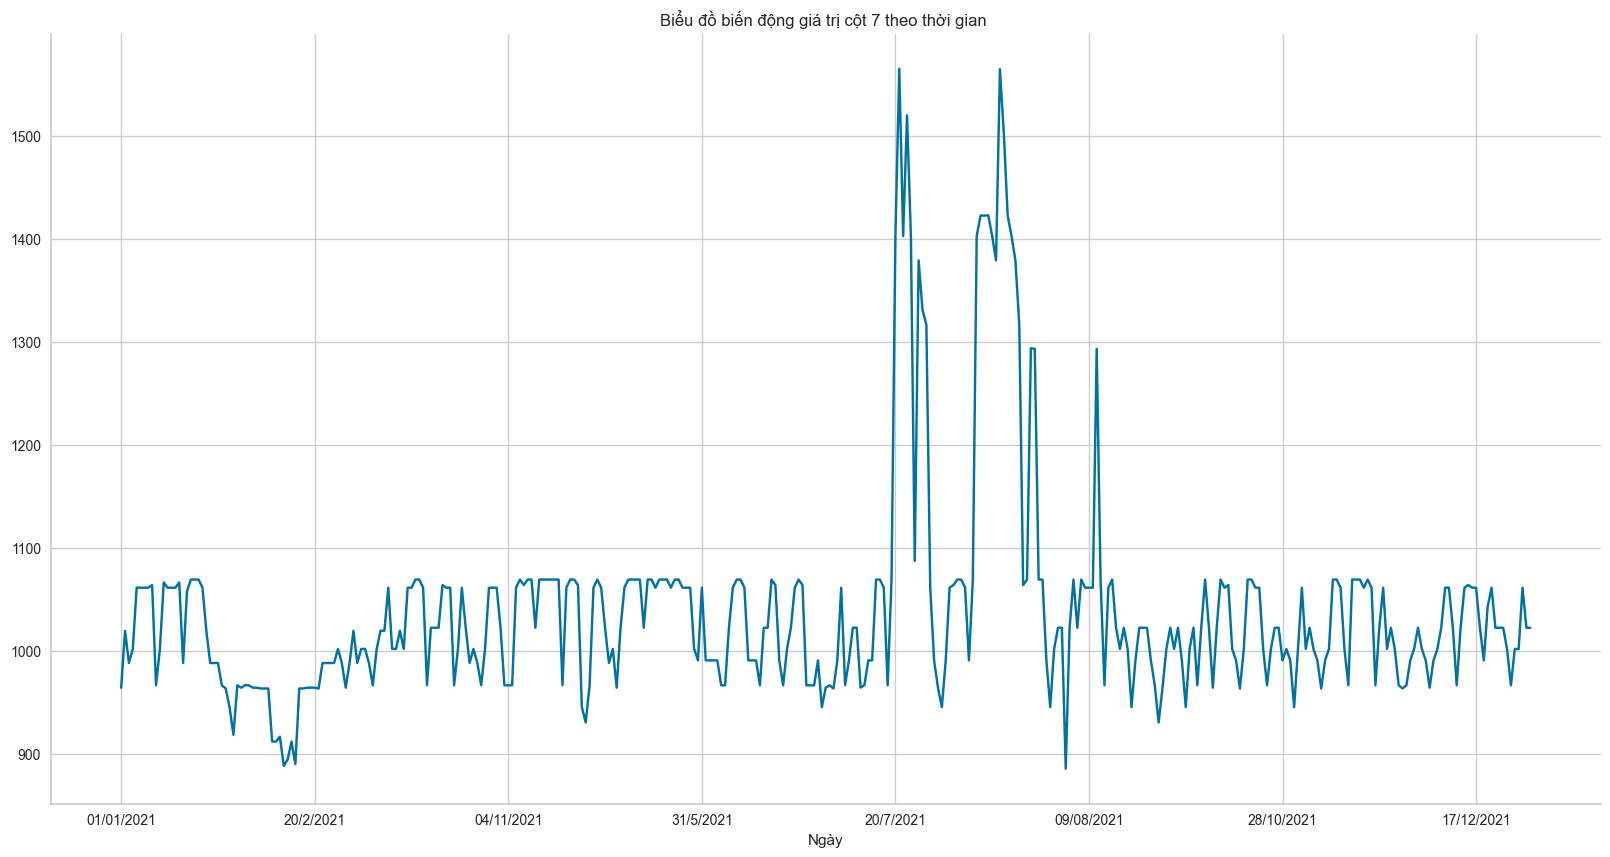

In [58]:
plt.figure(figsize=(20,10))
data['7'].plot(kind='line',figsize=(20,10),title="Biểu đồ biến động giá trị cột 7 theo thời gian ")
plt.gca().spines[['top','right']].set_visible(False)


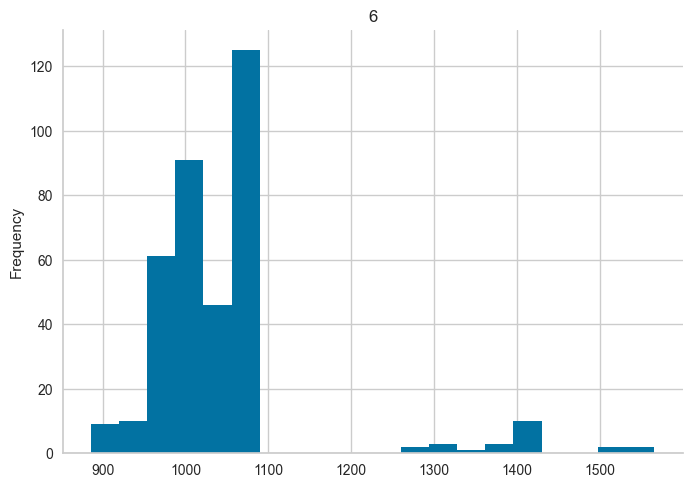

In [59]:
data['6'].plot(kind='hist', bins=20, title='6')
plt.gca().spines[['top', 'right',]].set_visible(False)

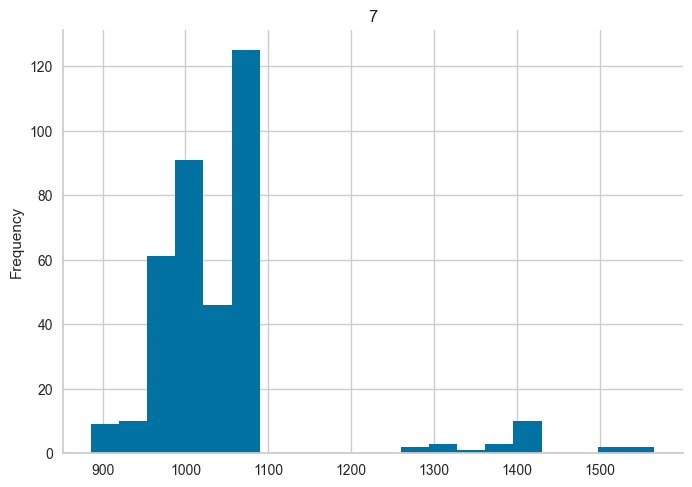

In [60]:
data['7'].plot(kind='hist', bins=20, title='7')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Gaussian

In [61]:
feats= ['6','7']

In [62]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(data[feats]).reshape(-1,1))

In [63]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
preds = BGM.fit_predict(X)


In [65]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X)
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [69]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 1.71072e-05
[400]	valid_0's multi_logloss: 1.71072e-05
[200]	valid_0's multi_logloss: 2.9727e-06
[400]	valid_0's multi_logloss: 2.9727e-06
[200]	valid_0's multi_logloss: 2.96634e-06
[400]	valid_0's multi_logloss: 2.96634e-06
[200]	valid_0's multi_logloss: 2.80756e-06
[400]	valid_0's multi_logloss: 2.80756e-06
[200]	valid_0's multi_logloss: 3.11811e-06
[400]	valid_0's multi_logloss: 3.11811e-06
[200]	valid_0's multi_logloss: 3.31111e-06
[400]	valid_0's multi_logloss: 3.31111e-06
[200]	valid_0's multi_logloss: 5.75321e-06
[400]	valid_0's multi_logloss: 5.75321e-06
[200]	valid_0's multi_logloss: 3.26431e-06
[400]	valid_0's multi_logloss: 3.26431e-06
[200]	valid_0's multi_logloss: 3.13843e-06
[400]	valid_0's multi_logloss: 3.13843e-06
[200]	valid_0's multi_logloss: 3.13837e-06
[400]	valid_0's multi_logloss: 3.13837e-06
[200]	valid_0's multi_logloss: 4.06637e-06
[400]	valid_0's multi_logloss: 4.06637e-06


In [71]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

In [72]:
labels=np.argmax(lgb_preds,axis=1)

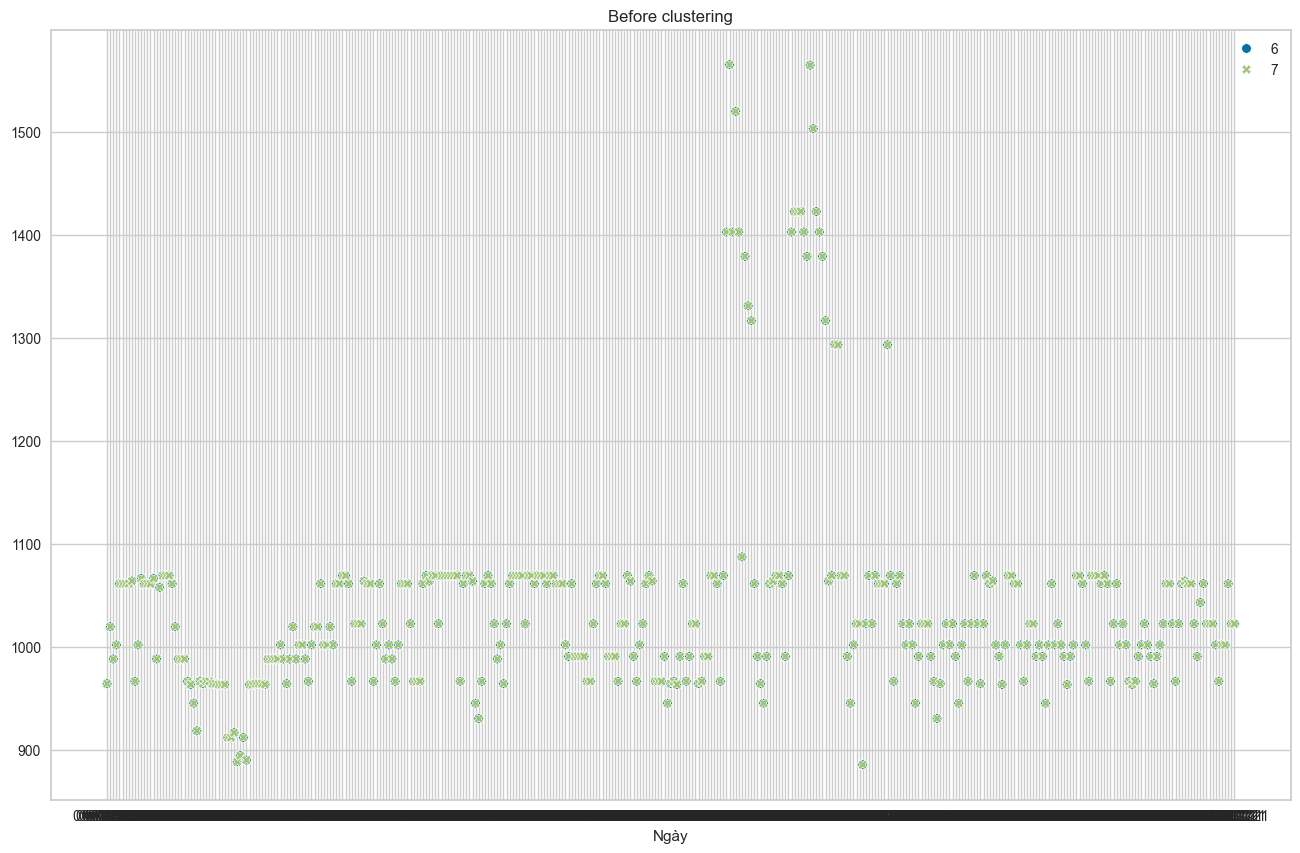

In [79]:
import seaborn as sns

fig = plt.figure(figsize=(16,10))
ax = plt.subplot(label="bla")
sns.scatterplot(data, marker='o');
ax.set_title("Before clustering");

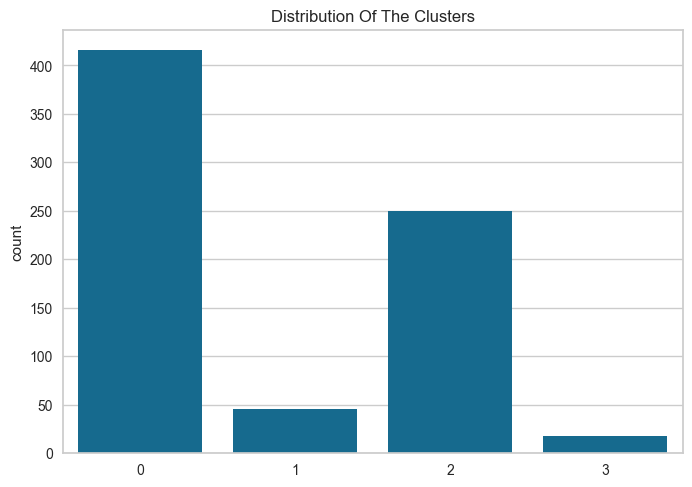

In [80]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

## Mô hình Sarima 

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [110]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['6'].values.reshape(-1,1))
scaler.fit(df['7'].values.reshape(-1,1))

MinMaxScaler()

In [111]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [112]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

In [113]:
train_data_6 = df['6'][:-test_size]
train_data_6 = scaler.transform(train_data_6.values.reshape(-1,1))
train_data_7 = df['7'][:-test_size]
train_data_7 = scaler.transform(train_data_7.values.reshape(-1,1))

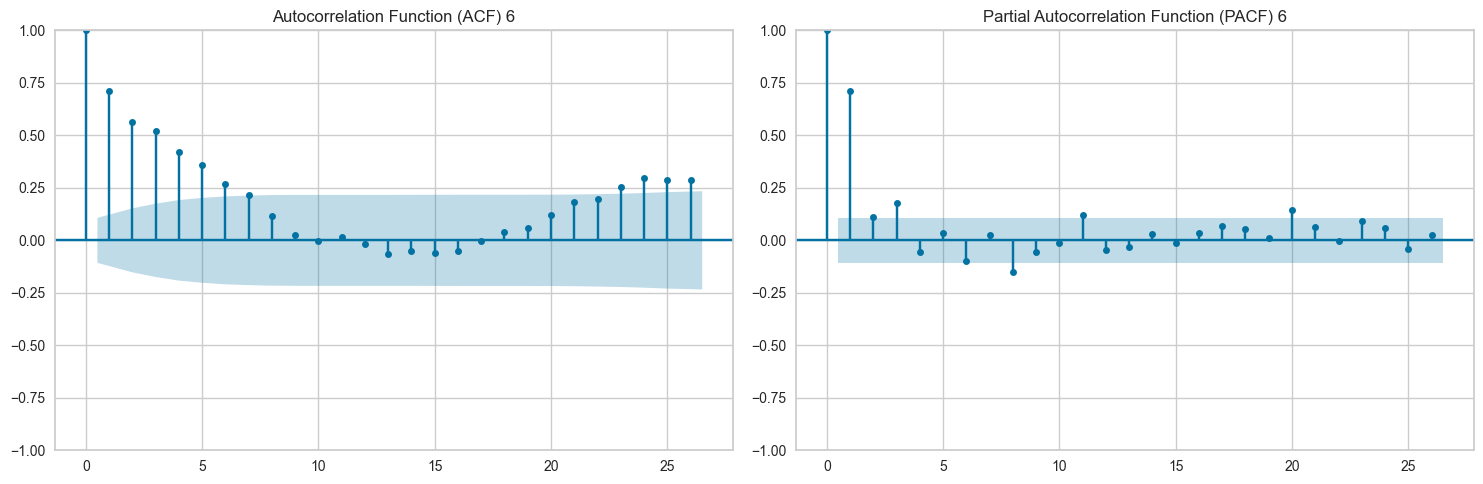

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(train_data_6, ax=ax1)
plot_pacf(train_data_6, ax=ax2)
ax1.set_title('Autocorrelation Function (ACF) 6')
ax2.set_title('Partial Autocorrelation Function (PACF) 6')
plt.tight_layout()
plt.show()

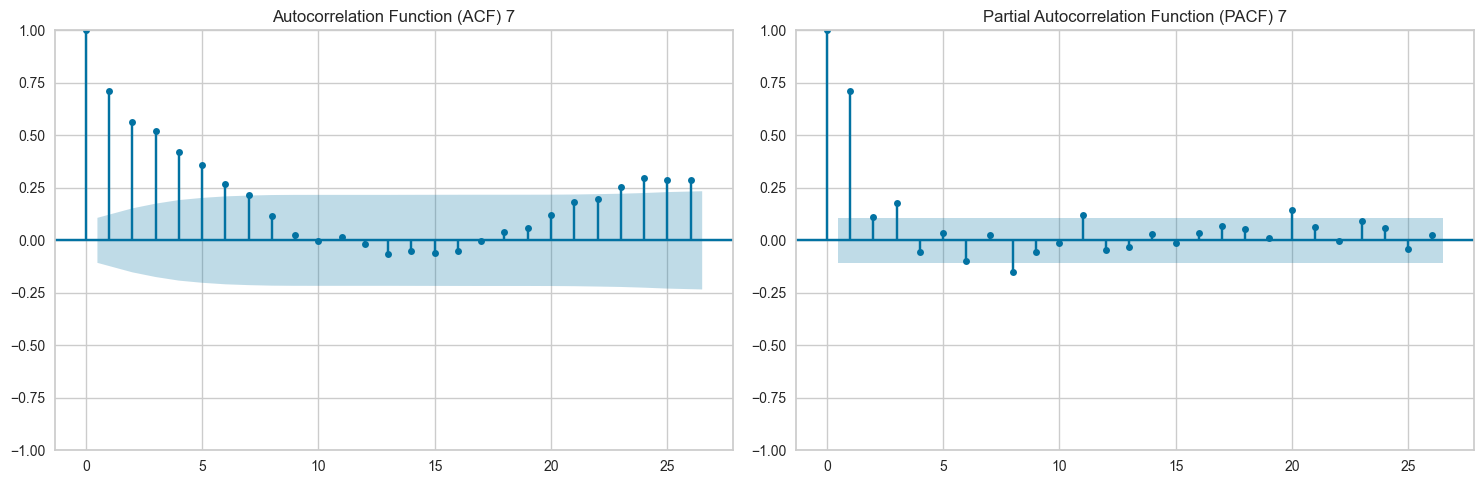

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(train_data_7, ax=ax1)
plot_pacf(train_data_7, ax=ax2)
ax1.set_title('Autocorrelation Function (ACF) 7')
ax2.set_title('Partial Autocorrelation Function (PACF) 7')
plt.tight_layout()
plt.show()

In [129]:
train_size = int(len(data) * 0.9)
df_train_6, df_test_6 = data['6'][:train_size], data['6'][train_size:]


In [130]:
train_size = int(len(data) * 0.9)
df_train_7, df_test_7 = data['7'][:train_size], data['7'][train_size:]


In [125]:
p, d, q = 3, 0, 1
P, D, Q, s = 3, 0, 1, 30

In [131]:
model_sarima = SARIMAX(df_train_6, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [132]:
model_sarima = SARIMAX(df_train_7, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [140]:
forecast_diff_6 = model_fit_sarima.forecast(steps=len(df_test_6))
print(forecast_diff_6)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


328     981.133790
329    1047.031091
330    1055.551005
331    1047.446237
332    1038.666320
333    1198.232447
334    1063.551394
335    1031.156016
336    1018.814761
337    1011.365110
338    1020.908098
339     975.167608
340    1022.832792
341    1053.633045
342    1059.628272
343    1049.397835
344    1056.517623
345    1154.089989
346    1127.489277
347    1016.465277
348    1015.150804
349    1020.674911
350    1044.650580
351     975.930221
352    1017.803358
353    1055.049030
354    1028.732732
355    1055.268164
356    1058.523750
357    1061.592064
358    1129.107087
359    1014.229708
360    1018.660036
361    1030.962665
362    1025.196333
363     993.148918
364    1031.678396
Name: predicted_mean, dtype: float64


In [141]:
df_pre_goc = forecast_diff_6.cumsum() + df_train_6.iloc[-1]
print(df_pre_goc)

328     1983.133790
329     3030.164881
330     4085.715886
331     5133.162123
332     6171.828443
333     7370.060890
334     8433.612283
335     9464.768299
336    10483.583060
337    11494.948170
338    12515.856268
339    13491.023876
340    14513.856668
341    15567.489713
342    16627.117985
343    17676.515820
344    18733.033442
345    19887.123431
346    21014.612709
347    22031.077985
348    23046.228789
349    24066.903700
350    25111.554280
351    26087.484501
352    27105.287859
353    28160.336889
354    29189.069621
355    30244.337785
356    31302.861536
357    32364.453600
358    33493.560686
359    34507.790394
360    35526.450430
361    36557.413095
362    37582.609428
363    38575.758346
364    39607.436742
Name: predicted_mean, dtype: float64


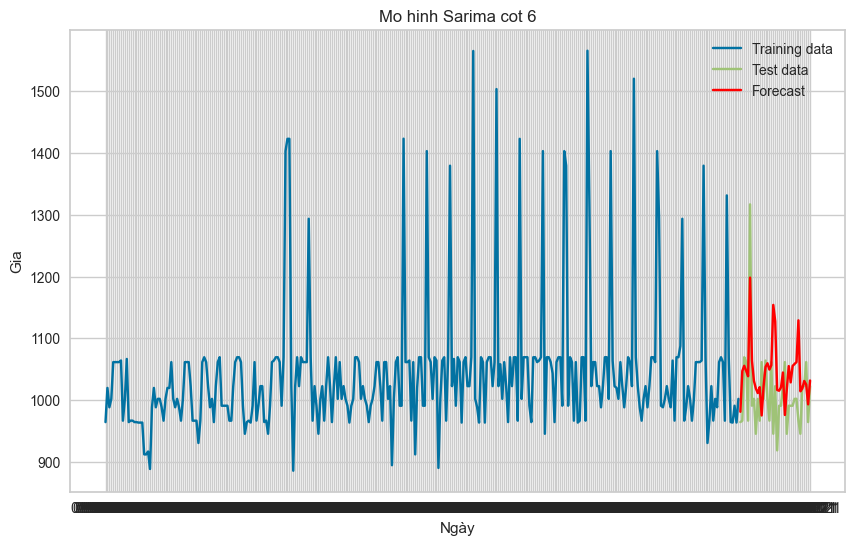

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(df_train_6.index, df_train_6, label='Training data')
plt.plot(df_test_6.index, df_test_6, label='Test data')
plt.plot(df_test_6.index, forecast_diff_6, color='red', label='Forecast')
plt.title('Mo hinh Sarima cot 6')
plt.xlabel('Ngày')
plt.ylabel('Gia')
plt.legend()
plt.show()

In [143]:
forecast_diff_7 = model_fit_sarima.forecast(steps=len(df_test_6))
print(forecast_diff_7)

328     981.133790
329    1047.031091
330    1055.551005
331    1047.446237
332    1038.666320
333    1198.232447
334    1063.551394
335    1031.156016
336    1018.814761
337    1011.365110
338    1020.908098
339     975.167608
340    1022.832792
341    1053.633045
342    1059.628272
343    1049.397835
344    1056.517623
345    1154.089989
346    1127.489277
347    1016.465277
348    1015.150804
349    1020.674911
350    1044.650580
351     975.930221
352    1017.803358
353    1055.049030
354    1028.732732
355    1055.268164
356    1058.523750
357    1061.592064
358    1129.107087
359    1014.229708
360    1018.660036
361    1030.962665
362    1025.196333
363     993.148918
364    1031.678396
Name: predicted_mean, dtype: float64


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [145]:
df_pre_goc = forecast_diff_7.cumsum() + df_train_7.iloc[-1]
print(df_pre_goc)

328     1983.133790
329     3030.164881
330     4085.715886
331     5133.162123
332     6171.828443
333     7370.060890
334     8433.612283
335     9464.768299
336    10483.583060
337    11494.948170
338    12515.856268
339    13491.023876
340    14513.856668
341    15567.489713
342    16627.117985
343    17676.515820
344    18733.033442
345    19887.123431
346    21014.612709
347    22031.077985
348    23046.228789
349    24066.903700
350    25111.554280
351    26087.484501
352    27105.287859
353    28160.336889
354    29189.069621
355    30244.337785
356    31302.861536
357    32364.453600
358    33493.560686
359    34507.790394
360    35526.450430
361    36557.413095
362    37582.609428
363    38575.758346
364    39607.436742
Name: predicted_mean, dtype: float64


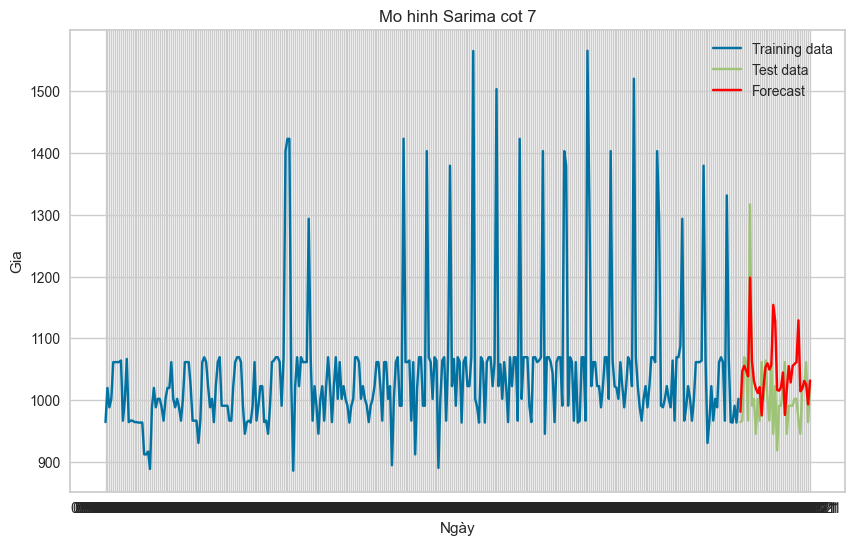

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(df_train_7.index, df_train_7, label='Training data')
plt.plot(df_test_7.index, df_test_7, label='Test data')
plt.plot(df_test_7.index, forecast_diff_7, color='red', label='Forecast')
plt.title('Mo hinh Sarima cot 7')
plt.xlabel('Ngày')
plt.ylabel('Gia')
plt.legend()
plt.show()